In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pickle

import torch
import torch.nn as nn
import torch.optim as optim

from module.data import Data
from module.model import *
from module.reschart import ResChart

c:\Users\pc\anaconda3\envs\ts\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


In [26]:
data = Data()
rc = ResChart

phi_list = [0.6, 0.8, 0.9]
theta_list = [0.5, -0.2]
shift = 0
window_size = 24
train_size = 12000
vali_size = 4000
test_size = 4000

input_size = 24
hidden_size = [24, 32, 48, 96, 128, 256]
num_layers = 1
output_size = 1
batch_size = [256]

learning_rate = 1e-05
learning_rate_decay = [True, False]
loss_fn = nn.MSELoss()

In [27]:
# greed search
record_60_5 = {}
record_80_5 = {}
record_90_5 = {}
record_90_2 = {}
for hs in hidden_size:
    for bs in batch_size:
        for lrd in learning_rate_decay:
            train_loader, vali_loader = data.load_data_train(phi_list = phi_list,
                                                             theta_list = theta_list, 
                                                             shift = shift, 
                                                             window_size = window_size, 
                                                             train_size = train_size, 
                                                             vali_size = vali_size, 
                                                             batch_size = bs, 
                                                             seed = True)
            lstm = LSTM_01(input_size, hs, num_layers, output_size, device).to(device)
            optimizer = optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=0.1)
            opt = Optimization(lstm, loss_fn, optimizer, learning_rate, lrd)

            print('>>>>>>>>>>>>>>>  start training for hiddensize={}, batchsize={}, decay={}  >>>>>>>>>>>>>>>'.format(hs, bs, lrd))
            opt.train(train_loader, vali_loader, epochs=300)

            PATH = './weights/lstm_hl_hs{}_bs{}_decay{}'.format(hs, bs, lrd)
            torch.save(lstm.state_dict(), PATH)
            
            res60_5 = rc.record_result(opt, test_size, 0.60, 0.5, shift, window_size, test_size)
            res80_5 = rc.record_result(opt, test_size, 0.80, 0.5, shift, window_size, test_size)
            res90_5 = rc.record_result(opt, test_size, 0.90, 0.5, shift, window_size, test_size)
            res90_2 = rc.record_result(opt, test_size, 0.90, -0.2, shift, window_size, test_size)
            
            print('phi=0.60, theta = 0.5 => error mean: {}, error std: {}'.format(np.mean(res60_5), np.std(res60_5)))
            print('phi=0.80, theta = 0.5 => error mean: {}, error std: {}'.format(np.mean(res80_5), np.std(res80_5)))
            print('phi=0.90, theta = 0.5 => error mean: {}, error std: {}'.format(np.mean(res90_5), np.std(res90_5)))
            print('phi=0.95, theta = -0.2 => error mean: {}, error std: {}'.format(np.mean(res90_2), np.std(res90_2)))

            record_60_5['hs{}_bs{}_decay{}'.format(hs, bs, lrd)] = 'mean: {}, std: {}'.format(np.mean(res60_5), np.std(res60_5))
            record_80_5['hs{}_bs{}_decay{}'.format(hs, bs, lrd)] = 'mean: {}, std: {}'.format(np.mean(res80_5), np.std(res80_5))
            record_90_5['hs{}_bs{}_decay{}'.format(hs, bs, lrd)] = 'mean: {}, std: {}'.format(np.mean(res90_5), np.std(res90_5))
            record_90_2['hs{}_bs{}_decay{}'.format(hs, bs, lrd)] = 'mean: {}, std: {}'.format(np.mean(res90_2), np.std(res90_2))


>>>>>>>>>>>>>>>  start training for hiddensize=24, batchsize=256, decay=True  >>>>>>>>>>>>>>>
[1/300] Training loss: 1.0311/t Validation loss: 1.0974
[2/300] Training loss: 1.0328/t Validation loss: 1.0951
[3/300] Training loss: 1.0305/t Validation loss: 1.0928
[4/300] Training loss: 1.0288/t Validation loss: 1.0905
[5/300] Training loss: 1.0258/t Validation loss: 1.0882
[6/300] Training loss: 1.0249/t Validation loss: 1.0859
[7/300] Training loss: 1.0222/t Validation loss: 1.0836
[8/300] Training loss: 1.0228/t Validation loss: 1.0814
[9/300] Training loss: 1.0144/t Validation loss: 1.0793
[10/300] Training loss: 1.0192/t Validation loss: 1.0772
[30/300] Training loss: 0.9875/t Validation loss: 1.0366
[60/300] Training loss: 0.9439/t Validation loss: 0.9767
[90/300] Training loss: 0.8963/t Validation loss: 0.9103
[120/300] Training loss: 0.8789/t Validation loss: 0.8867
[150/300] Training loss: 0.8806/t Validation loss: 0.8867
[180/300] Training loss: 0.8801/t Validation loss: 0.8867


KeyboardInterrupt: 

In [ ]:
import pickle
with open('record_60_5_hl1.pkl', 'wb') as f1:
    pickle.dump(record_60_5, f1)
f1.close()
with open('record_80_5_hl1.pkl', 'wb') as f2:
    pickle.dump(record_80_5, f2)
f2.close()
with open('record_90_5_hl1.pkl', 'wb') as f3:
    pickle.dump(record_90_5, f3)
f3.close()
with open('record_90_2_hl1.pkl', 'wb') as f5:
    pickle.dump(record_90_2, f5)
f5.close()

In [60]:
# print("--------------------------------phi=0.60, theta=0.5----------------------------")
# with open('record_60_5_hl1.pkl', 'rb') as f:
#     record_1 = pickle.load(f)
# for key in record_1:
#     print(f'hidden_batch_learningrate: {key} => {record_1[key]}')

print("--------------------------------phi=0.80, theta=0.5----------------------------")
with open('record_80_5_hl1.pkl', 'rb') as f:
    record_2 = pickle.load(f)
for key in record_2:
    print(f'hidden_batch_learningrate: {key} => {record_2[key]}')

print("--------------------------------phi=0.90, theta=0.5----------------------------")
with open('record_90_5_hl1.pkl', 'rb') as f:
    record_3 = pickle.load(f)
for key in record_3:
    print(f'hidden_batch_learningrate: {key} => {record_3[key]}')

print("--------------------------------phi=0.90, theta=-0.2----------------------------")
with open('record_90_2_hl1.pkl', 'rb') as f:
    record_4 = pickle.load(f)
for key in record_4:
    print(f'hidden_batch_learningrate: {key} => {record_4[key]}')



--------------------------------phi=0.80, theta=0.5----------------------------
hidden_batch_learningrate: hs24_bs256_decayTrue => mean: 0.18175539422071338, std: 0.9829044574365711
hidden_batch_learningrate: hs24_bs256_decayFalse => mean: -0.13956444226447612, std: 0.8772636330878366
hidden_batch_learningrate: hs32_bs256_decayTrue => mean: -0.4466124979916528, std: 0.9536897519067209
hidden_batch_learningrate: hs32_bs256_decayFalse => mean: -0.28200054056204377, std: 0.8527473867601358
hidden_batch_learningrate: hs48_bs256_decayTrue => mean: -0.3061088367407597, std: 0.851136589006682
hidden_batch_learningrate: hs48_bs256_decayFalse => mean: -0.2871118211367521, std: 1.1530466733541034
hidden_batch_learningrate: hs96_bs256_decayTrue => mean: -0.21444952561557337, std: 0.9637255192356116
hidden_batch_learningrate: hs96_bs256_decayFalse => mean: -0.2565395049205329, std: 1.3149263720564297
hidden_batch_learningrate: hs128_bs256_decayTrue => mean: -0.23988848659460277, std: 1.13781975346

# phi = 0.25

In [3]:
data = Data()
rc = ResChart

data = Data()
rc = ResChart

phi_list = [0.6, 0.8, 0.9]
theta_list = [0.5, -0.2]

shift = 0
window_size = 24

train_size = 12000
vali_size = 4000
test_size = 4000

input_size = 24
hidden_size = 128
num_layers = 1
output_size = 1
batch_size = 256

learning_rate = 0.00001
learning_rate_decay = False
loss_fn = nn.MSELoss()

In [4]:
lstm = LSTM(input_size, hidden_size, num_layers, output_size, device).to(device)
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay = 0.1)
opt = Optimization(lstm, loss_fn, optimizer, learning_rate, False)

In [5]:
train_loader, vali_loader = data.load_data_train(phi_list = phi_list,
                                                theta_list = theta_list, 
                                                shift = shift, 
                                                window_size = window_size, 
                                                train_size = train_size, 
                                                vali_size = vali_size, 
                                                batch_size = batch_size, 
                                                seed = True)
print('>>>>>>>>>>>>>>>  start training for hiddensize={}, batchsize={}, decay={}  >>>>>>>>>>>>>>>'.format(hidden_size, batch_size, learning_rate_decay))
opt.train(train_loader, vali_loader, epochs=300)

PATH = './weights/lstm_hl_hs{}_bs{}_decay{}'.format(hidden_size, batch_size, learning_rate_decay)
torch.save(lstm.state_dict(), PATH)


>>>>>>>>>>>>>>>  start training for hiddensize=128, batchsize=256, decay=False  >>>>>>>>>>>>>>>
[1/300] Training loss: 1.0101/t Validation loss: 1.0669
[2/300] Training loss: 1.0057/t Validation loss: 1.0574
[3/300] Training loss: 0.9964/t Validation loss: 1.0482
[4/300] Training loss: 0.9913/t Validation loss: 1.0393
[5/300] Training loss: 0.9835/t Validation loss: 1.0305
[6/300] Training loss: 0.9778/t Validation loss: 1.0222
[7/300] Training loss: 0.9710/t Validation loss: 1.0136
[8/300] Training loss: 0.9657/t Validation loss: 1.0054
[9/300] Training loss: 0.9587/t Validation loss: 0.9976
[10/300] Training loss: 0.9538/t Validation loss: 0.9895
[30/300] Training loss: 0.8368/t Validation loss: 0.8430
[60/300] Training loss: 0.6916/t Validation loss: 0.6656
[90/300] Training loss: 0.5915/t Validation loss: 0.5486
[120/300] Training loss: 0.5297/t Validation loss: 0.4760
[150/300] Training loss: 0.4708/t Validation loss: 0.4302
Early Stopping in: 1/20
[180/300] Training loss: 0.4473/

In [6]:
PATH = './weights/lstm_hl_hs128_bs256_decayFalse'
state_dict = torch.load(PATH)
lstm = lstm.load_state_dict(state_dict)

In [7]:
fixed_seed = 3121
random.seed(fixed_seed)
np.random.seed(fixed_seed)
torch.manual_seed(fixed_seed)

test_loader, mean, std, targets = data.load_data_preds(4000, 0.90, -0.2, shift, window_size, 4000)
        
preds_25, targets = opt.evaluate(test_loader)
preds_25 = preds_25*std + mean

res, ebar = rc.ebar(preds_25, targets)
np.mean(res), np.std(res)

(-0.013808642999081204, 0.997339738937189)

In [8]:
mae = rc.mae(res)
mae

0.7996269420800233

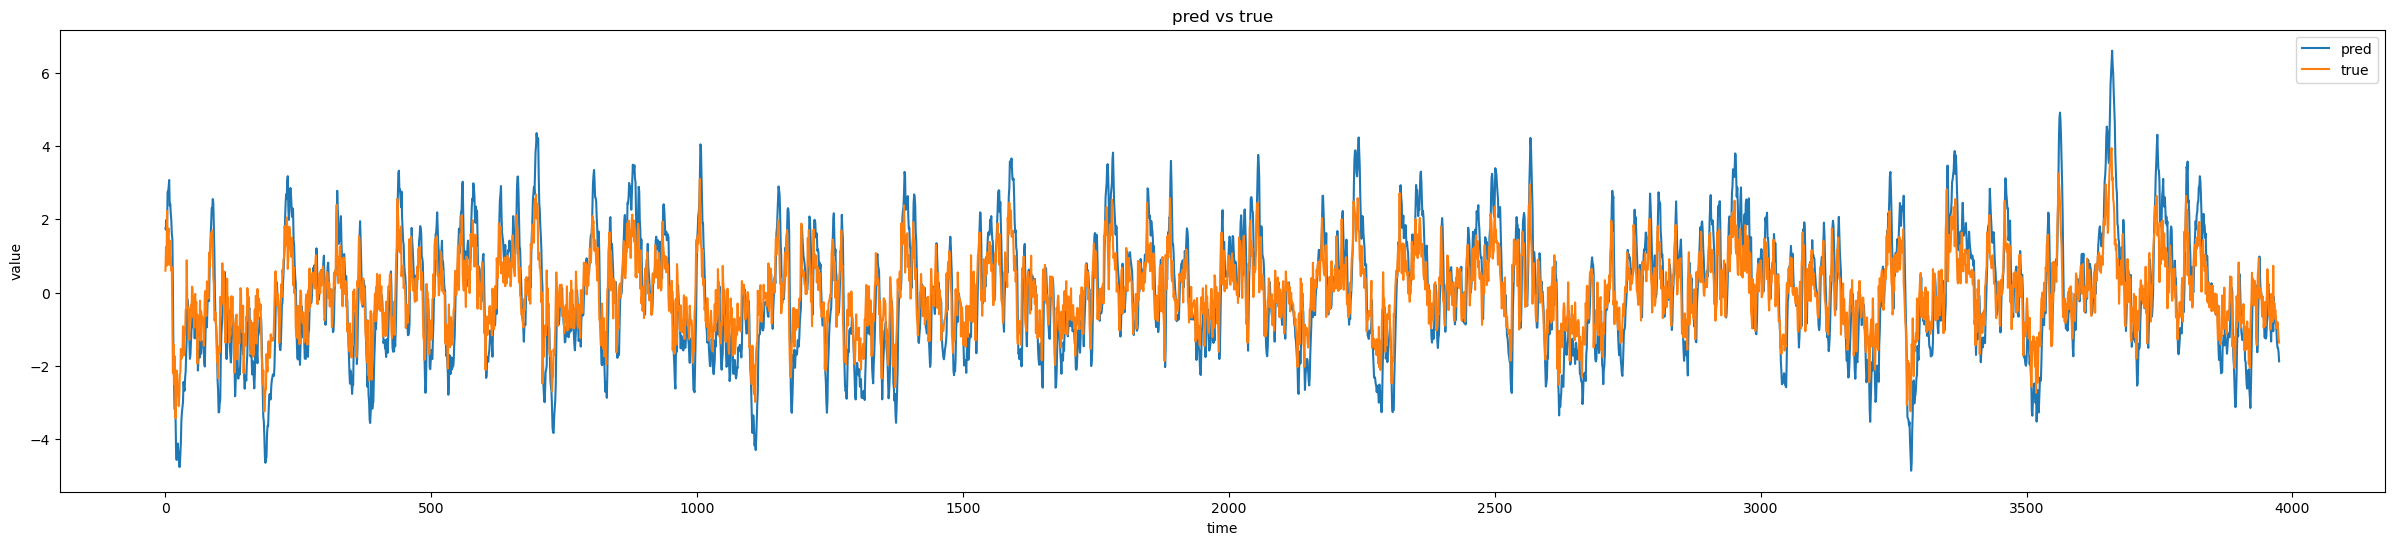

In [9]:
plt.figure(figsize=(30,6))
plt.plot(preds_25)
plt.plot(targets)
plt.xlabel('time')
plt.ylabel('value')
plt.title('pred vs true')
plt.legend(('pred', 'true'))

In [20]:
# ucl, lcl
l_list = np.arange(3.6, 3.7, 0.01).tolist()

upper_cl = []
lower_cl = []

for l in l_list:
    ucl, lcl = rc.control_limit(ebar, mae, l)
    upper_cl.append(ucl)
    lower_cl.append(lcl)

arl_list = {}
for l in l_list:
    arl_list[l] = 0

In [21]:
count = 100
phi = 0.9
theta = -0.2
test_size = 4000
shift = 0
window_size = 24
batch_size = 4000

for c in tqdm(range(count)):
    for i, l in enumerate(l_list):
        arl_list[l] += rc.arl0(opt, test_size, phi, theta, shift, window_size, upper_cl[i], lower_cl[i])     
        
for key in arl_list:
    arl_list[key] = arl_list[key]/count

for key in arl_list:
    print(f'l: {key} arl: {arl_list[key]}')
    

100%|██████████| 100/100 [01:27<00:00,  1.14it/s]

l: 3.6 arl: 285.4
l: 3.61 arl: 366.19
l: 3.6199999999999997 arl: 307.98
l: 3.6299999999999994 arl: 313.88
l: 3.6399999999999992 arl: 336.51
l: 3.649999999999999 arl: 355.04
l: 3.659999999999999 arl: 372.2
l: 3.6699999999999986 arl: 388.58
l: 3.6799999999999984 arl: 378.9
l: 3.689999999999998 arl: 435.27
l: 3.699999999999998 arl: 436.33


In [22]:
ucl, lcl = rc.control_limit(ebar, mae, 3.66)
ucl, lcl

(2.912825965013804, -2.9404432510119665)

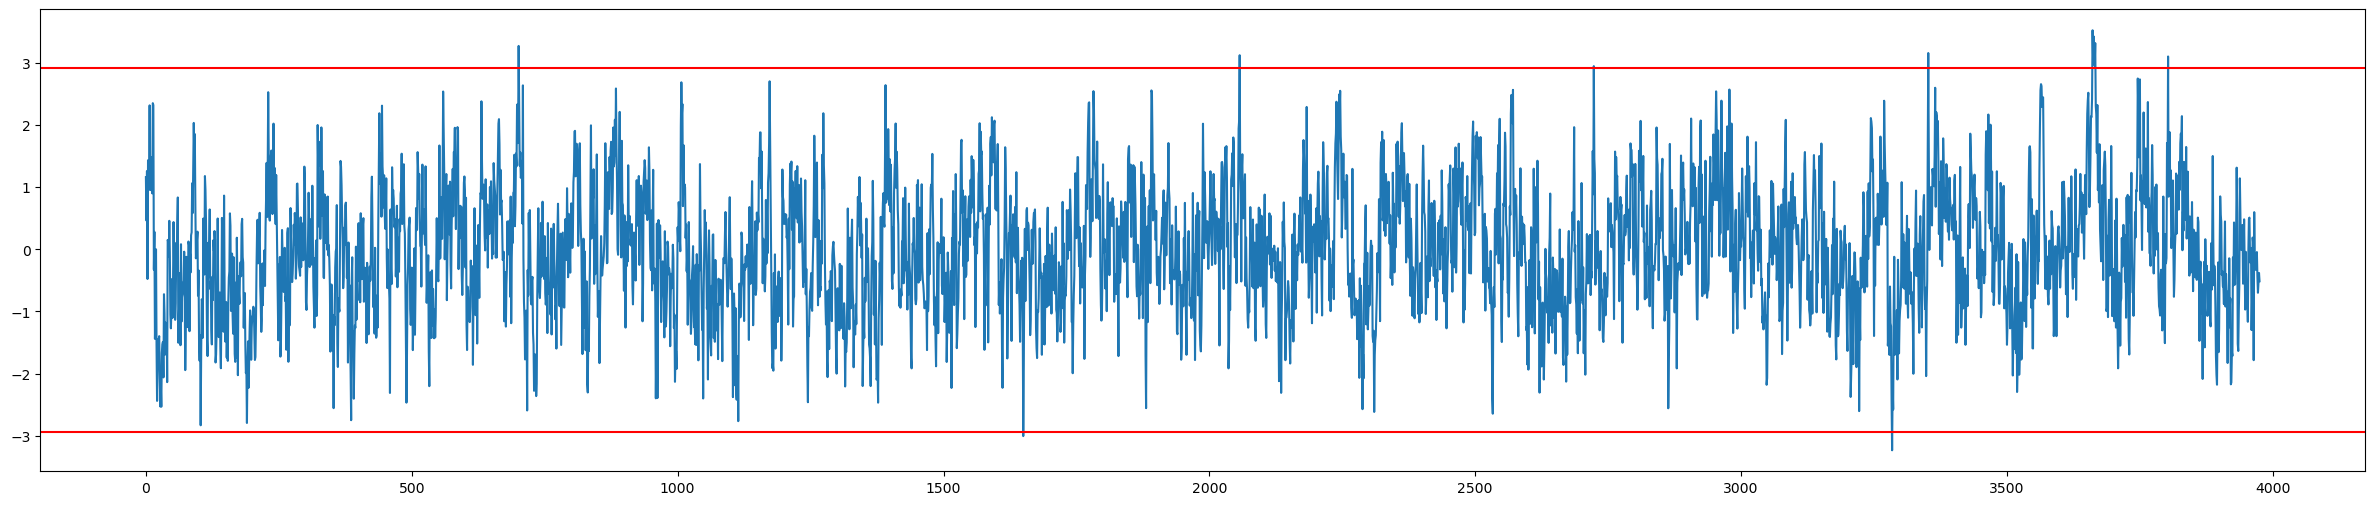

In [23]:
plt.figure(figsize=(30, 6))
plt.plot(res)
plt.axhline(ucl, color='red')
plt.axhline(lcl, color='red')

In [24]:
# def arl1(model, size, phi, shift, window_size, batch_size, ucl, lcl):
shift_list = [0.5, 1, 2, 3]
phi = 0.80
theta = 0.5

count = 100
arl = {}
sub = {}
for shift in shift_list:
    arl[shift] = 0
    sub[shift] = count

for t in tqdm(range(count)):
    for shift in shift_list:
        rl, sub_count = rc.arl1(opt, test_size, phi, theta, shift, window_size, batch_size, ucl, lcl)
        arl[shift] += rl
        sub[shift] -= sub_count
        if sub[shift] == 0:
            print("shift = ", shift,"error: all rl's are under 70")
            continue

for shift in arl:
    if(sub[shift] == 0):
        break
    else:
        arl[shift] /= sub[shift]
        print('shift size = {} => arl1 = {}'.format(shift, arl[shift]))

100%|██████████| 100/100 [01:01<00:00,  1.62it/s]

shift =  2 error: all rl's are under 70
shift =  3 error: all rl's are under 70
shift size = 0.5 => arl1 = 8.307692307692308
shift size = 1 => arl1 = 5.2


# phi = 0.5

In [ ]:
data = Data()
rc = ResChart

phi_list = [0.6, 0.8, 0.9]
theta_list = [0.5, -0.2]

train_size = 12000
vali_size = 4000
shift = 0
window_size = 24

input_size = 24
hidden_size = 24
num_layers = 1
output_size = 1
batch_size = 258

learning_rate = 0.00001
learning_rate_decay = True
loss_fn = nn.MSELoss()

In [ ]:
lstm = LSTM(input_size, hidden_size, num_layers, output_size, device).to(device)
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=0.1)
opt = Optimization(lstm, loss_fn, optimizer, learning_rate, False)

In [ ]:
PATH = './weights/lstm_hl1_hs24_bs258_decayTrue'
state_dict = torch.load(PATH)
lstm = lstm.load_state_dict(state_dict)

In [ ]:
fixed_seed = 302
random.seed(fixed_seed)
np.random.seed(fixed_seed)
torch.manual_seed(fixed_seed)

test_loader, mean, std, targets = data.load_data_preds(2000, 0.5, shift, window_size, 2000)
        
preds, targets = opt.evaluate(test_loader)
preds = preds*std + mean

res, ebar = rc.ebar(preds, targets)
np.mean(res), np.std(res)

In [ ]:
mae = rc.mae(res)
mae

In [ ]:
plt.figure(figsize=(30,6))
plt.plot(preds)
plt.plot(targets)
plt.xlabel('time')
plt.ylabel('value')
plt.title('pred vs true')
plt.legend(('pred', 'true'))

In [ ]:
# ucl, lcl
# l_list = np.arange(3.75, 3.85, 0.01).tolist()
l_list = np.array([3.7])
upper_cl = []
lower_cl = []

for l in l_list:
    ucl, lcl = rc.control_limit(ebar, mae, l)
    upper_cl.append(ucl)
    lower_cl.append(lcl)

arl_list = {}
for l in l_list:
    arl_list[l] = 0
upper_cl

In [ ]:
count = 1000
phi = 0.5
test_size = 2000
shift = 0
window_size = 24
batch_size = 2000

for c in tqdm(range(count)):
    for i, l in enumerate(l_list):
        arl_list[l] += rc.arl0(opt, test_size, phi, shift, window_size, upper_cl[i], lower_cl[i])     
        
for key in arl_list:
    arl_list[key] = arl_list[key]/count

for key in arl_list:
    print(f'l: {key} arl: {arl_list[key]}')
    

In [ ]:
ucl, lcl = rc.control_limit(ebar, mae, 3.75)
ucl, lcl

In [ ]:
plt.figure(figsize=(30, 6))
plt.plot(res)
plt.axhline(ucl, color='red')
plt.axhline(lcl, color='red')

In [ ]:
# def arl1(model, size, phi, shift, window_size, batch_size, ucl, lcl):
shift_list = [0.5, 1, 2, 3]
phi = 0.5

count = 100
arl = {}
sub = {}
for shift in shift_list:
    arl[shift] = 0
    sub[shift] = count


for t in tqdm(range(count)):
    for shift in shift_list:
        rl, sub_count = rc.arl1(opt, test_size, phi, shift, window_size, batch_size, ucl, lcl)
        arl[shift] += rl
        sub[shift] -= sub_count

for shift in arl:
    arl[shift] /= sub[shift]

for shift in arl:
    print('shift size = {} => arl1 = {}'.format(shift, arl[shift]))

# phi = 0.75

In [ ]:
data = Data()
rc = ResChart

shift = 0
window_size = 24
input_size = 24
hidden_size = 32
num_layers = 1
output_size = 1
batch_size = 258

learning_rate = 0.00001
learning_rate_decay = True
loss_fn = nn.MSELoss()

In [ ]:
lstm = LSTM(input_size, hidden_size, num_layers, output_size, device).to(device)
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=0.1)
opt = Optimization(lstm, loss_fn, optimizer, learning_rate, False)

In [ ]:
PATH = './weights/lstm_hl3_hs32_bs258_decayTrue'
state_dict = torch.load(PATH)
lstm = lstm.load_state_dict(state_dict)

In [ ]:
fixed_seed = 302
random.seed(fixed_seed)
np.random.seed(fixed_seed)
torch.manual_seed(fixed_seed)

test_loader, mean, std, targets = data.load_data_preds(2000, 0.75, shift, window_size, 2000)
        
preds, targets = opt.evaluate(test_loader)
preds = preds*std + mean

res, ebar = rc.ebar(preds, targets)
np.mean(res), np.std(res)

In [ ]:
mae = rc.mae(res)
mae

In [ ]:
plt.figure(figsize=(30,6))
plt.plot(preds)
plt.plot(targets)
plt.xlabel('time')
plt.ylabel('value')
plt.title('pred vs true')
plt.legend(('pred', 'true'))

In [ ]:
# ucl, lcl
# l_list = np.arange(3.0, 4.0, 0.1).tolist()
l_list = np.array([3.7])

upper_cl = []
lower_cl = []

for l in l_list:
    ucl, lcl = rc.control_limit(ebar, mae, l)
    upper_cl.append(ucl)
    lower_cl.append(lcl)

arl_list = {}
for l in l_list:
    arl_list[l] = 0
upper_cl

In [ ]:
count = 100
phi = 0.25
test_size = 2000
shift = 0
window_size = 24
batch_size = 2000

for c in tqdm(range(count)):
    for i, l in enumerate(l_list):
        arl_list[l] += rc.arl0(opt, test_size, phi, shift, window_size, upper_cl[i], lower_cl[i])     
        
for key in arl_list:
    arl_list[key] = arl_list[key]/count

for key in arl_list:
    print(f'l: {key} arl: {arl_list[key]}')
    

In [ ]:
ucl, lcl = rc.control_limit(ebar, mae, 3.81)
ucl, lcl

In [ ]:
plt.figure(figsize=(30, 6))
plt.plot(res)
plt.axhline(ucl, color='red')
plt.axhline(lcl, color='red')

In [ ]:
# def arl1(model, size, phi, shift, window_size, batch_size, ucl, lcl):
shift_list = [0.5, 1, 2, 3]
phi = 0.75

count = 100
arl = {}
sub = {}
for shift in shift_list:
    arl[shift] = 0
    sub[shift] = count


for t in tqdm(range(count)):
    for shift in shift_list:
        rl, sub_count = rc.arl1(opt, test_size, phi, shift, window_size, batch_size, ucl, lcl)
        arl[shift] += rl
        sub[shift] -= sub_count

for shift in arl:
    arl[shift] /= sub[shift]

for shift in arl:
    print('shift size = {} => arl1 = {}'.format(shift, arl[shift]))

# phi = 0.95

In [ ]:
data = Data()
rc = ResChart

phi_list = [0, 0.25, 0.5, 0.75, 0.95]
shift = 0
window_size = 24
train_size = 6000
vali_size = 2000
test_size = 2000

input_size = 24
hidden_size = 24
num_layers = 1
output_size = 1
batch_size = 258

learning_rate = 0.00001
learning_rate_decay = True
loss_fn = nn.MSELoss()

In [ ]:
lstm = LSTM(input_size, hidden_size, num_layers, output_size, device).to(device)
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=0.1)
opt = Optimization(lstm, loss_fn, optimizer, learning_rate, False)

In [ ]:
PATH = './weights/lstm_hl1_hs24_bs258_decayTrue'
state_dict = torch.load(PATH)
lstm = lstm.load_state_dict(state_dict)

In [ ]:
fixed_seed = 302
random.seed(fixed_seed)
np.random.seed(fixed_seed)
torch.manual_seed(fixed_seed)

test_loader, mean, std, targets = data.load_data_preds(2000, 0.25, shift, window_size, 2000)
        
preds, targets = opt.evaluate(test_loader)
preds = preds*std + mean

res, ebar = rc.ebar(preds, targets)
np.mean(res), np.std(res)

In [ ]:
mae = rc.mae(res)
mae

In [ ]:
plt.figure(figsize=(30,6))
plt.plot(preds)
plt.plot(targets)
plt.xlabel('time')
plt.ylabel('value')
plt.title('pred vs true')
plt.legend(('pred', 'true'))

In [ ]:
# ucl, lcl
l_list = np.arange(3.78, 3.85, 0.01).tolist()

upper_cl = []
lower_cl = []

for l in l_list:
    ucl, lcl = rc.control_limit(ebar, mae, l)
    upper_cl.append(ucl)
    lower_cl.append(lcl)

arl_list = {}
for l in l_list:
    arl_list[l] = 0
upper_cl

In [ ]:
count = 5000
phi = 0.25
test_size = 2000
shift = 0
window_size = 24
batch_size = 2000

for c in tqdm(range(count)):
    for i, l in enumerate(l_list):
        arl_list[l] += rc.arl0(opt, test_size, phi, shift, window_size, upper_cl[i], lower_cl[i])     
        
for key in arl_list:
    arl_list[key] = arl_list[key]/count

for key in arl_list:
    print(f'l: {key} arl: {arl_list[key]}')
    

In [ ]:
ucl, lcl = rc.control_limit(ebar, mae, 3.81)
ucl, lcl

In [ ]:
plt.figure(figsize=(30, 6))
plt.plot(res)
plt.axhline(ucl, color='red')
plt.axhline(lcl, color='red')

In [ ]:
# def arl1(model, size, phi, shift, window_size, batch_size, ucl, lcl):
shift_list = [0.5, 1, 2, 3]
phi = 0.25

count = 100
arl = {}
sub = {}
for shift in shift_list:
    arl[shift] = 0
    sub[shift] = count


for t in tqdm(range(count)):
    for shift in shift_list:
        rl, sub_count = rc.arl1(opt, test_size, phi, shift, window_size, batch_size, ucl, lcl)
        arl[shift] += rl
        sub[shift] -= sub_count

for shift in arl:
    arl[shift] /= sub[shift]

for shift in arl:
    print('shift size = {} => arl1 = {}'.format(shift, arl[shift]))